In [2]:
import timm
from torchsummary import summary
import torch
from torch import nn
import torch.nn.functional as F
from importlib import reload
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import albumentations
from albumentations import augmentations
from tqdm import tqdm
from tqdm import tqdm_notebook
from torch.utils.data import DataLoader

In [24]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [15]:
base_model = timm.create_model(
            "tf_efficientnet_b4_ns", pretrained=True, num_classes=1, in_chans=54
        )
summary(base_model, (54,256,256), device='cpu')

Layer (type:depth-idx)                        Output Shape              Param #
├─Conv2dSame: 1-1                             [-1, 48, 128, 128]        23,328
├─BatchNorm2d: 1-2                            [-1, 48, 128, 128]        96
├─SwishMe: 1-3                                [-1, 48, 128, 128]        --
├─Sequential: 1-4                             [-1, 448, 8, 8]           --
|    └─Sequential: 2-1                        [-1, 24, 128, 128]        --
|    |    └─DepthwiseSeparableConv: 3-1       [-1, 24, 128, 128]        2,940
|    |    └─DepthwiseSeparableConv: 3-2       [-1, 24, 128, 128]        1,206
|    └─Sequential: 2-2                        [-1, 32, 64, 64]          --
|    |    └─InvertedResidual: 3-3             [-1, 32, 64, 64]          11,878
|    |    └─InvertedResidual: 3-4             [-1, 32, 64, 64]          18,120
|    |    └─InvertedResidual: 3-5             [-1, 32, 64, 64]          18,120
|    |    └─InvertedResidual: 3-6             [-1, 32, 64, 64]          1

Layer (type:depth-idx)                        Output Shape              Param #
├─Conv2dSame: 1-1                             [-1, 48, 128, 128]        23,328
├─BatchNorm2d: 1-2                            [-1, 48, 128, 128]        96
├─SwishMe: 1-3                                [-1, 48, 128, 128]        --
├─Sequential: 1-4                             [-1, 448, 8, 8]           --
|    └─Sequential: 2-1                        [-1, 24, 128, 128]        --
|    |    └─DepthwiseSeparableConv: 3-1       [-1, 24, 128, 128]        2,940
|    |    └─DepthwiseSeparableConv: 3-2       [-1, 24, 128, 128]        1,206
|    └─Sequential: 2-2                        [-1, 32, 64, 64]          --
|    |    └─InvertedResidual: 3-3             [-1, 32, 64, 64]          11,878
|    |    └─InvertedResidual: 3-4             [-1, 32, 64, 64]          18,120
|    |    └─InvertedResidual: 3-5             [-1, 32, 64, 64]          18,120
|    |    └─InvertedResidual: 3-6             [-1, 32, 64, 64]          1

In [20]:
import classifier
reload(classifier)
from classifier import ClassifierConv
c = ClassifierConv(21*448)
summary(c, (21*448,8,8), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
├─SeparableConvBnAct: 1-1                [-1, 2352, 8, 8]          --
|    └─Conv2d: 2-1                       [-1, 9408, 8, 8]          84,672
|    └─Conv2d: 2-2                       [-1, 2352, 8, 8]          22,127,616
|    └─BatchNormAct2d: 2-3               [-1, 2352, 8, 8]          --
|    |    └─ReLU: 3-1                    [-1, 2352, 8, 8]          --
├─MaxPool2d: 1-2                         [-1, 2352, 6, 6]          --
├─Dropout2d: 1-3                         [-1, 2352, 6, 6]          --
├─SeparableConvBnAct: 1-4                [-1, 1568, 6, 6]          --
|    └─Conv2d: 2-4                       [-1, 2352, 6, 6]          21,168
|    └─Conv2d: 2-5                       [-1, 1568, 6, 6]          3,687,936
|    └─BatchNormAct2d: 2-6               [-1, 1568, 6, 6]          --
|    |    └─ReLU: 3-2                    [-1, 1568, 6, 6]          --
├─MaxPool2d: 1-5                         [-1, 1568, 4, 4]     

Layer (type:depth-idx)                   Output Shape              Param #
├─SeparableConvBnAct: 1-1                [-1, 2352, 8, 8]          --
|    └─Conv2d: 2-1                       [-1, 9408, 8, 8]          84,672
|    └─Conv2d: 2-2                       [-1, 2352, 8, 8]          22,127,616
|    └─BatchNormAct2d: 2-3               [-1, 2352, 8, 8]          --
|    |    └─ReLU: 3-1                    [-1, 2352, 8, 8]          --
├─MaxPool2d: 1-2                         [-1, 2352, 6, 6]          --
├─Dropout2d: 1-3                         [-1, 2352, 6, 6]          --
├─SeparableConvBnAct: 1-4                [-1, 1568, 6, 6]          --
|    └─Conv2d: 2-4                       [-1, 2352, 6, 6]          21,168
|    └─Conv2d: 2-5                       [-1, 1568, 6, 6]          3,687,936
|    └─BatchNormAct2d: 2-6               [-1, 1568, 6, 6]          --
|    |    └─ReLU: 3-2                    [-1, 1568, 6, 6]          --
├─MaxPool2d: 1-5                         [-1, 1568, 4, 4]     

In [27]:
print("Parameters : ", sum(p.numel() for p in ui.parameters() if p.requires_grad))

Parameters :  25220411


In [4]:
import segmentation.timm_efficientnet
reload(segmentation.timm_efficientnet)
from segmentation.timm_efficientnet import EfficientNet
eff = EfficientNet()
print(eff)
# summary(eff, (3,256,256))

EfficientNet(
  (encoder): Encoder(
    (stem): Sequential(
      (0): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (3): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
          (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          )
          (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_sta

In [6]:
print(eff.state_dict().keys())

odict_keys(['encoder.stem.0.weight', 'encoder.stem.1.weight', 'encoder.stem.1.bias', 'encoder.stem.1.running_mean', 'encoder.stem.1.running_var', 'encoder.stem.1.num_batches_tracked', 'encoder.blocks.3.0.conv_dw.weight', 'encoder.blocks.3.0.bn1.weight', 'encoder.blocks.3.0.bn1.bias', 'encoder.blocks.3.0.bn1.running_mean', 'encoder.blocks.3.0.bn1.running_var', 'encoder.blocks.3.0.bn1.num_batches_tracked', 'encoder.blocks.3.0.se.conv_reduce.weight', 'encoder.blocks.3.0.se.conv_reduce.bias', 'encoder.blocks.3.0.se.conv_expand.weight', 'encoder.blocks.3.0.se.conv_expand.bias', 'encoder.blocks.3.0.conv_pw.weight', 'encoder.blocks.3.0.bn2.weight', 'encoder.blocks.3.0.bn2.bias', 'encoder.blocks.3.0.bn2.running_mean', 'encoder.blocks.3.0.bn2.running_var', 'encoder.blocks.3.0.bn2.num_batches_tracked', 'encoder.blocks.3.1.conv_dw.weight', 'encoder.blocks.3.1.bn1.weight', 'encoder.blocks.3.1.bn1.bias', 'encoder.blocks.3.1.bn1.running_mean', 'encoder.blocks.3.1.bn1.running_var', 'encoder.blocks.3.

In [8]:
from segmentation.merged_net import SRM_Classifer

merged = SRM_Classifer()
print(merged.state_dict().keys())

odict_keys(['srm_conv.weight', 'bayer_conv.weight', 'rgb_conv.weight', 'ela_net.0.weight', 'ela_net.1.weight', 'ela_net.1.bias', 'ela_net.1.running_mean', 'ela_net.1.running_var', 'ela_net.1.num_batches_tracked', 'ela_net.3.weight', 'ela_net.4.weight', 'ela_net.4.bias', 'ela_net.4.running_mean', 'ela_net.4.running_var', 'ela_net.4.num_batches_tracked', 'encoder.stem.0.weight', 'encoder.stem.1.weight', 'encoder.stem.1.bias', 'encoder.stem.1.running_mean', 'encoder.stem.1.running_var', 'encoder.stem.1.num_batches_tracked', 'encoder.blocks.3.0.conv_dw.weight', 'encoder.blocks.3.0.bn1.weight', 'encoder.blocks.3.0.bn1.bias', 'encoder.blocks.3.0.bn1.running_mean', 'encoder.blocks.3.0.bn1.running_var', 'encoder.blocks.3.0.bn1.num_batches_tracked', 'encoder.blocks.3.0.se.conv_reduce.weight', 'encoder.blocks.3.0.se.conv_reduce.bias', 'encoder.blocks.3.0.se.conv_expand.weight', 'encoder.blocks.3.0.se.conv_expand.bias', 'encoder.blocks.3.0.conv_pw.weight', 'encoder.blocks.3.0.bn2.weight', 'encode

In [4]:
from segmentation.timm_efficientnet import EfficientNet
enc = EfficientNet().get_encoder()
inp = torch.randn((1,3,256,256))

x, (start, end), smp = enc(inp)

In [6]:
for i in start.keys():
    print(i, " :", start[i].size())

block_0_layer_0  : torch.Size([1, 24, 128, 128])
block_1_layer_2  : torch.Size([1, 32, 64, 64])
block_2_layer_6  : torch.Size([1, 56, 32, 32])
block_3_layer_10  : torch.Size([1, 112, 16, 16])


In [7]:
for i in end.keys():
    print(i, " :", end[i].size())

block_0_layer_1  : torch.Size([1, 24, 128, 128])
block_1_layer_5  : torch.Size([1, 32, 64, 64])
block_2_layer_9  : torch.Size([1, 56, 32, 32])
block_4_layer_21  : torch.Size([1, 160, 16, 16])


In [2]:
# reload(segmentation.timm_unetb4)
from segmentation.timm_unetb4 import UnetB4, UnetB4_Inception
from segmentation.timm_unetpp import UnetPP
from segmentation.timm_efficientnet import EfficientNet

# unetpp = UnetPP(encoder=EfficientNet().get_encoder())
unetb4 = UnetB4(encoder=EfficientNet().get_encoder())
# unetb4_inc = UnetB4_Inception(encoder=EfficientNet().get_encoder())

In [1]:
# unetb4_inc.encoder.unfreeze()
sum(p.numel() for p in eff.parameters() if p.requires_grad)

NameError: name 'eff' is not defined

In [4]:
(unetb4(torch.randn(1,3,224,224))).shape

torch.Size([1, 1, 224, 224])

In [11]:
reload(classifier)
from classifier import ClassifierBlock
clsf = ClassifierBlock(21*448)

In [12]:
sum(p.numel() for p in clsf.parameters() if p.requires_grad)

5853706

In [11]:
out = torch.randn((4,21,1792))

In [8]:
z = torch.nn.functional.adaptive_avg_pool1d(out.permute(0,2,1), 1).squeeze()
z.shape

torch.Size([4, 1792])

In [9]:
# y = torch.mean(out,dim=1,keepdims=True)
# print(y.shape)
print(z.shape)
mlp = nn.Sequential(
    nn.Linear(1792, 1792 // 16, bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(1792 // 16, 1792, bias=True),
    nn.ReLU(inplace=True)
)
y = mlp(z)
print(y.shape)
# y = y*out
# print(y.shape)

torch.Size([4, 1792])
torch.Size([4, 1792])


In [23]:
import classifier
reload(classifier)
from classifier import Classifier_GAP
clf = Classifier_GAP(1792)
y = clf(out)
print(y.shape)
print(y)
print("Parameters : ", sum(p.numel() for p in clf.parameters() if p.requires_grad))

torch.Size([4, 1])
tensor([[0.0159],
        [0.0171],
        [0.0597],
        [0.0110]], grad_fn=<AddmmBackward>)
Parameters :  405105


In [2]:
import classifier_dataset
reload(classifier_dataset)
from classifier_dataset import Classifier_Dataset

DATA_ROOT = f"Image_Manipulation_Dataset/CASIA_2.0/1792_tensors"
df = pd.read_csv(f"casia_1792_tensors.csv").sample(frac=1).reset_index(drop=True)
dataset = Classifier_Dataset(
    dataframe=df,
    mode="train",
    val_fold=0,
    test_fold=9,
    root_dir=DATA_ROOT,
    equal_sample=False,
)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=8)

real:2400, fakes:2400, mode = train


In [3]:
for batch in train_loader:
    print(batch['tensor'])
    print(batch['label'].shape)
    break

tensor([[[-5.1632e-03,  1.2604e-02,  2.9091e-02,  ...,  2.7968e-02,
          -5.4697e-02, -1.4012e-02],
         [-9.5029e-02, -5.5731e-02, -3.4164e-02,  ..., -3.9931e-17,
           3.4622e-22, -3.7107e-18],
         [-9.4913e-02, -5.5731e-02, -3.4164e-02,  ..., -3.9931e-17,
           3.4622e-22, -3.7107e-18],
         ...,
         [-2.2991e-03, -3.4626e-03, -1.3350e-03,  ...,  7.1714e-03,
          -8.5065e-04, -9.2385e-04],
         [-2.1138e-03, -3.8303e-03, -1.0879e-03,  ...,  9.3847e-03,
          -4.8313e-04, -1.4868e-04],
         [-4.0777e-03, -3.3981e-03, -3.5067e-03,  ...,  1.4127e-03,
          -4.1024e-03, -1.8493e-03]],

        [[-3.9656e-02, -1.7297e-02, -2.1789e-02,  ..., -1.7849e-02,
          -7.4701e-02, -5.4930e-02],
         [-9.2829e-02, -5.5731e-02, -3.4164e-02,  ..., -3.9931e-17,
           3.4622e-22, -3.7107e-18],
         [-1.4150e-01, -5.5731e-02, -3.4164e-02,  ..., -3.9931e-17,
           3.4622e-22, -3.7107e-18],
         ...,
         [-9.4403e-03, -5

In [33]:
data = dataset[0]
data['tensor'].size()

torch.Size([21, 1792])

In [57]:
class Classifier2(nn.Module):
    def __init__(self, in_channels):
        super(Classifier2, self).__init__()
        
        self.gap1D = nn.AdaptiveAvgPool1d(output_size=1)
        ### Fully Connected Multi-Layer Perceptron (FC-MLP)
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, in_channels // 16, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // 16, in_channels, bias=False),
            nn.Sigmoid()
        )
        self.fc = nn.Linear(in_channels, 1)
    def forward(self, x):
        print(x.size())
        y = x.permute((0,2,1))
        print(y.size())
        y = self.gap1D(y).squeeze(-1)
        print(y.size())
        y = self.mlp(y).unsqueeze(1)
        x =  x * y
        print(x.size())
        # x = nn.functional.dropout(x, p=0.3)
        x = x.permute((0,2,1))
        print(x.size())
        x = self.gap1D(x).squeeze(-1)
        print(x.size())
        x = self.fc(x)
        print(x.size())
        return x
cls = Classifier2(32)

In [63]:
cls.eval()
with torch.no_grad():
    out = cls(a.unsqueeze(0))
    print(out.size())
    print(out)

torch.Size([1, 4, 32])
torch.Size([1, 32, 4])
torch.Size([1, 32])
torch.Size([1, 4, 32])
torch.Size([1, 32, 4])
torch.Size([1, 32])
torch.Size([1, 1])
torch.Size([1, 1])
tensor([[-0.0875]])


In [55]:
class Classifierold(nn.Module):
    def __init__(self, in_channels):
        super(Classifierold, self).__init__()
        
        self.gap1D = nn.AdaptiveAvgPool1d(output_size=1)
        
        ### Fully Connected Multi-Layer Perceptron (FC-MLP)
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, in_channels // 16, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // 16, in_channels, bias=False),
            nn.Sigmoid()
        )
        self.fc = nn.Linear(in_channels, 1)
        
    def forward(self, x):
        y = x.T.unsqueeze(0)
        y = self.gap1D(y).squeeze(-1)
        y = self.mlp(y)
        x =  x * y
        
        # x = nn.functional.dropout(x, p=0.3)
        x = x.T.unsqueeze(0)
        x = self.gap1D(x).squeeze(-1)
        
        x = self.fc(x)
        
        return x
clso = Classifierold(32)

In [64]:
clso.eval()
with torch.no_grad():
    out = clso(a)
    print(out.size())
    print(out)

torch.Size([1, 1])
tensor([[0.0641]])


In [71]:
from classifier import ClassifierBlock

classifier = ClassifierBlock(8960)
out = classifier(res)
out.size()

torch.Size([1, 4480, 5, 5])
torch.Size([1, 1792, 3, 3])
torch.Size([1, 1792, 3, 3])
torch.Size([1, 1792, 1, 1])


torch.Size([1, 1])

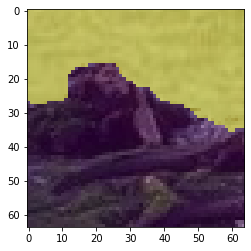

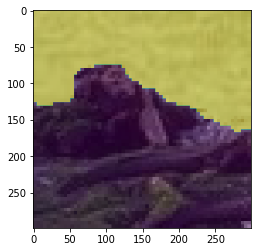

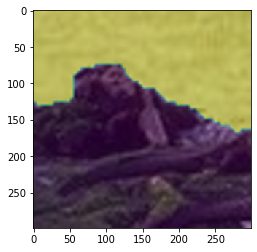

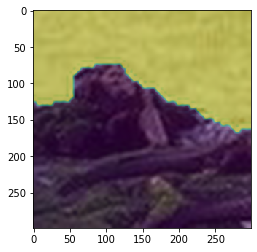

In [65]:
import cv2
import matplotlib.pyplot as plt 

img = cv2.imread('G:\\Image_Manipulation_Dataset\\CASIA_2.0\\image_patch_64\\Tp_D_CND_M_N_ani00018_sec00096_00138\\0.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
msk = cv2.imread('G:\\Image_Manipulation_Dataset\\CASIA_2.0\\image_patch_64\\Tp_D_CND_M_N_ani00018_sec00096_00138\\0_gt.png', cv2.IMREAD_GRAYSCALE)

plt.figure()
plt.imshow(img)
plt.imshow(msk, alpha=0.5)
plt.show()

img1 = cv2.resize(img, (299,299), interpolation=cv2.INTER_AREA)
msk1 = cv2.resize(msk, (299,299), interpolation=cv2.INTER_AREA)
plt.figure()
plt.imshow(img1)
plt.imshow(msk1, alpha=0.5)
plt.show()

img2 = cv2.resize(img, (299,299), interpolation=cv2.INTER_CUBIC)
msk2 = cv2.resize(msk, (299,299), interpolation=cv2.INTER_CUBIC)
plt.figure()
plt.imshow(img2)
plt.imshow(msk2, alpha=0.5)
plt.show()

img3 = cv2.resize(img, (299,299), interpolation=cv2.INTER_LANCZOS4)
msk3 = cv2.resize(msk, (299,299), interpolation=cv2.INTER_LANCZOS4)
plt.figure()
plt.imshow(img3)
plt.imshow(msk3, alpha=0.5)
plt.show()

here
here


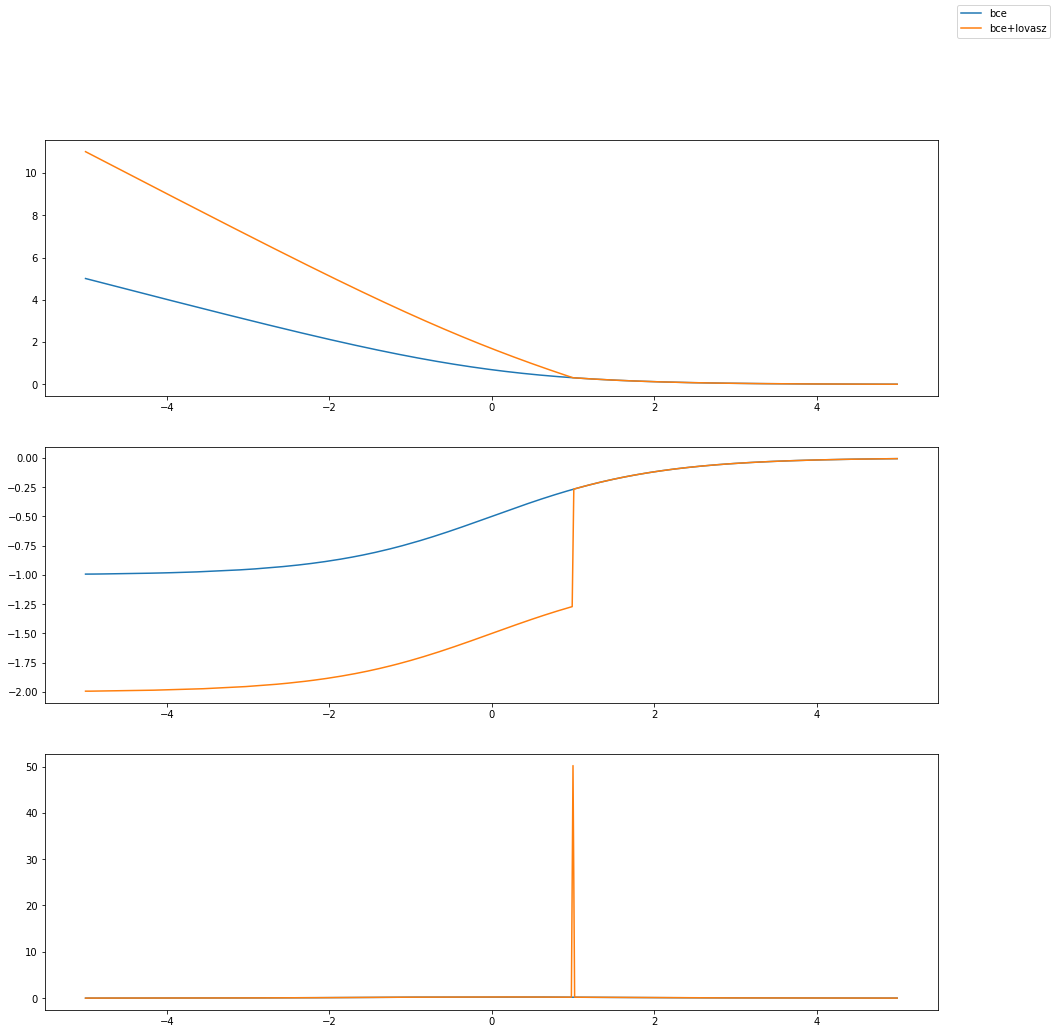

In [2]:
from torch.nn import BCEWithLogitsLoss

from pytorch_toolbelt import losses as L
import numpy as np
import torch
import matplotlib.pyplot as plt


losses = {
    "bce": BCEWithLogitsLoss(),
    # "focal": L.BinaryFocalLoss(),
    # "jaccard": L.BinaryJaccardLoss(),
    # "jaccard_log": L.BinaryJaccardLogLoss(),
    # "dice": L.BinaryDiceLoss(),
    # "dice_log": L.BinaryDiceLogLoss(),
    # "sdice": L.BinarySymmetricDiceLoss(),
    # "sdice_log": L.BinarySymmetricDiceLoss(log_loss=True),
    "bce+lovasz": L.JointLoss(BCEWithLogitsLoss(), L.BinaryLovaszLoss()),
    # "lovasz": L.BinaryLovaszLoss(),
    # "bce+jaccard": L.JointLoss(BCEWithLogitsLoss(),
    #                            L.BinaryJaccardLoss(), 1, 0.5),
    # "bce+log_jaccard": L.JointLoss(BCEWithLogitsLoss(),
    #                            L.BinaryJaccardLogLoss(), 1, 0.5),
    # "bce+log_dice": L.JointLoss(BCEWithLogitsLoss(),
    #                                L.BinaryDiceLogLoss(), 1, 0.5)
    # "reduced_focal": L.BinaryFocalLoss(reduced=True)
}

dx = 0.01
x_vec = torch.arange(-5, 5, dx).view(-1, 1).expand((-1, 100))

f, ax = plt.subplots(3, figsize=(16, 16))

for name, loss in losses.items():
    print('here')
    x_arr = []
    y_arr = []
    target = torch.tensor(1.0).view(1).expand((100))

    for x in x_vec:
        y = loss(x, target).item()

        x_arr.append(float(x[0]))
        y_arr.append(float(y))

    ax[0].plot(x_arr, y_arr, label=name)
    ax[1].plot(x_arr, np.gradient(y_arr, dx))
    ax[2].plot(x_arr, np.gradient(np.gradient(y_arr, dx), dx))

f.legend()
f.show()

In [33]:
from metrics import dice_score

a = torch.randn((4,1,3,3))
b = torch.ones_like(a)
print(a.size(), b.size())
dice = dice_score(a,b)

torch.Size([4, 1, 3, 3])torch.Size([4, 1, 3, 3])
tensor(16.5668)
tensor(52.5668)
tensor(0.6303)
tensor(16.5668)
tensor(52.5668)
tensor(0.6303)


In [51]:
def DiceCoeff(outputs, targets):
    eps = 1e-7
    outputs = torch.sigmoid(outputs)
    intersection = torch.sum(targets * outputs)
    print('inter',intersection)
    union = torch.sum(targets) + torch.sum(outputs)
    print('un',union)
    dice = ((2 * intersection) + eps) / (union + eps)
    print(dice)
    return dice

s = torch.FloatTensor(1).zero_()

for i, c in enumerate(zip(a, b)):
    print(c[0].size())
    s = s + DiceCoeff(c[0], c[1])
print(s)
print(s / (i + 1))

torch.Size([1, 3, 3])
intertensor(3.9308)
untensor(12.9308)
tensor(0.6080)
torch.Size([1, 3, 3])
intertensor(4.7343)
untensor(13.7343)
tensor(0.6894)
torch.Size([1, 3, 3])
intertensor(4.3832)
untensor(13.3832)
tensor(0.6550)
torch.Size([1, 3, 3])
intertensor(3.5186)
untensor(12.5186)
tensor(0.5621)
tensor([2.5145])
tensor([0.6286])


In [49]:
DiceCoeff(a,b)

tensor(16.5668)
tensor(52.5668)
tensor(0.6303)


tensor(0.6303)

In [46]:
def soft_dice_score(
    output: torch.Tensor, target: torch.Tensor, smooth: float = 0.0, eps: float = 1e-7, dims=None
) -> torch.Tensor:
    """
    :param output:
    :param target:
    :param smooth:
    :param eps:
    :return:
    Shape:
        - Input: :math:`(N, NC, *)` where :math:`*` means any number
            of additional dimensions
        - Target: :math:`(N, NC, *)`, same shape as the input
        - Output: scalar.
    """
    assert output.size() == target.size()
    if dims is not None:
        intersection = torch.sum(output * target, dim=dims)
        cardinality = torch.sum(output + target, dim=dims)
    else:
        intersection = torch.sum(output * target)
        print(intersection)
        cardinality = torch.sum(output + target)
        print(cardinality)
    dice_score = (2.0 * intersection + smooth) / (cardinality + smooth).clamp_min(eps)
    return dice_score

In [53]:
soft_dice_score(torch.sigmoid(a),b)

tensor(16.5668)
tensor(52.5668)


tensor(0.6303)

In [24]:
image = cv2.imread('G:\\Image_Manipulation_Dataset\\CASIA_2.0\\Tp\\Tp_D_CNN_M_N_ani00057_ani00055_11149.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

import albumentations
from albumentations import augmentations

image = albumentations.Compose(
        [
            augmentations.transforms.Resize(
                256, 256, interpolation=cv2.INTER_AREA, always_apply=True, p=1
            )
        ]
    )(image=image)['image']

reload(segmentation.timm_efficientnet)
from segmentation.timm_efficientnet import EfficientNet
model = EfficientNet(freeze_encoder=True).get_encoder()

In [2]:
from segmentation.timm_efficientnet import EfficientNet
import image_ensemble
reload(image_ensemble)
from image_ensemble import ensemble

patch_size = 'FULL'
DATA_ROOT = f"Image_Manipulation_Dataset/CASIA_2.0"
df = pd.read_csv(f"casia_{patch_size}.csv").sample(frac=1).reset_index(drop=True)
model = EfficientNet().get_encoder().cuda()

In [5]:
image = cv2.imread('Image_Manipulation_Dataset/CASIA_2.0/Tp/Tp_D_CNN_M_N_ani00057_ani00055_11149.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (256,256), interpolation=cv2.INTER_AREA)

out = ensemble(model, image)
out.shape

--------- Loaded Checkpoint: 256_encoder.h5 ----------
torch.Size([1, 448, 8, 8])
--------- Loaded Checkpoint: 128_encoder.h5 ----------
torch.Size([4, 448, 8, 8])
--------- Loaded Checkpoint: 64_encoder.h5 ----------
torch.Size([16, 448, 8, 8])


torch.Size([21, 448, 8, 8])

In [28]:
df = pd.read_csv('casia_FULL.csv')
df['tensor'] = -1
print(len(df))
df.head()

12593


,image_patch,mask_patch,label,fold,ela,tensor
0,Au/Au_arc_30272.jpg,NaN,0,0,Au/Au_arc_30272_ela.jpg,-1
1,Tp/Tp_D_NNN_S_N_nat20015_nat20018_01519.tif,Gt/Tp_D_NNN_S_N_nat20015_nat20018_01519_gt.png,1,0,Tp/Tp_D_NNN_S_N_nat20015_nat20018_01519_ela.jpg,-1
2,Tp/Tp_D_NRN_S_N_cha10108_cha00062_11584.jpg,Gt/Tp_D_NRN_S_N_cha10108_cha00062_11584_gt.png,1,0,Tp/Tp_D_NRN_S_N_cha10108_cha00062_11584_ela.jpg,-1
3,Tp/Tp_S_NNN_M_N_cha00044_cha00044_11008.jpg,Gt/Tp_S_NNN_M_N_cha00044_cha00044_11008_gt.png,1,0,Tp/Tp_S_NNN_M_N_cha00044_cha00044_11008_ela.jpg,-1
4,Tp/Tp_D_NRN_S_N_nat00063_art00025_11437.jpg,Gt/Tp_D_NRN_S_N_nat00063_art00025_11437_gt.png,1,0,Tp/Tp_D_NRN_S_N_nat00063_art00025_11437_ela.jpg,-1


In [4]:
DIR = 'Image_Manipulation_Dataset/CASIA_2.0/448_tensors'
with tqdm_notebook(total=df.shape[0]) as pbar:
    for i, row in df.iterrows():
        fname = row['image_patch'].split('/')[-1][:-4]
        if os.path.exists(os.path.join(DIR, fname+".pt")):
            df.loc[i, 'tensor'] = fname+".pt"
        else:
            image = cv2.imread(os.path.join(DATA_ROOT, row['image_patch']))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (256,256), interpolation=cv2.INTER_AREA)
            # plt.imshow(image)
            # plt.show()
            tensor = ensemble(model, image)
            tensor = tensor.cpu()
            torch.save(tensor, os.path.join(DIR, fname+".pt"))
            df.loc[i, 'tensor'] = fname+".pt"
        pbar.update(1)

In [7]:
df.to_csv('casia_tensor_448.csv', index=False)

In [7]:
from casia_dataset import CASIA

patch_size = 'FULL'
DATA_ROOT = f"Image_Manipulation_Dataset/CASIA_2.0"
df = pd.read_csv(f"casia_{patch_size}.csv").sample(frac=1).reset_index(drop=True)

normalize = {
    "mean": [0.42468103282400615, 0.4259826707370029, 0.38855473517307415],
    "std": [0.2744059987371694, 0.2684138285232067, 0.29527622263685294],
}
valid_aug = albumentations.Compose(
    [
        augmentations.transforms.Resize(224, 224, interpolation=cv2.INTER_AREA, always_apply=True, p=1),
        albumentations.Normalize(mean=normalize['mean'], std=normalize['std'], always_apply=True, p=1),
        albumentations.pytorch.ToTensor()
    ],
    additional_targets={'ela':'image'}
)
valid_dataset = CASIA(
    dataframe=df,
    mode="val",
    val_fold=0,
    test_fold=9,
    root_dir=DATA_ROOT,
    patch_size=patch_size,
    equal_sample=False,
    transforms=valid_aug,
)

real:750, fakes:510, mode = val


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
torch.Size([3, 224, 224])


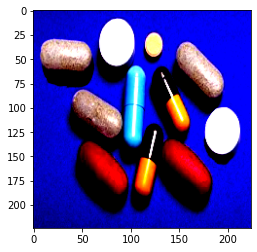

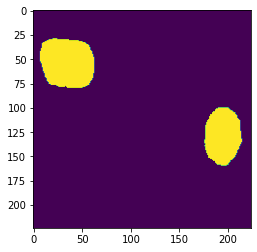

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


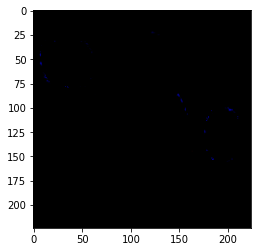

In [37]:
data = valid_dataset[5]
print(data['image'].size())
plt.figure()
plt.imshow(data['image'].permute((1,2,0)))
plt.show()
plt.figure()
plt.imshow(data['mask'].permute((1,2,0)).squeeze())
plt.show()
plt.figure()
plt.imshow(data['ela'].permute((1,2,0)).squeeze())
plt.show()

In [35]:
def dice_score(
    outputs: torch.Tensor,
    targets: torch.Tensor,
    eps: float = 1e-7,
    threshold: float = None,
):

    if threshold is not None:
        outputs = (outputs > threshold).float()

    intersection = torch.sum(targets * outputs)
    union = torch.sum(targets + outputs)
    dice = ((2 * intersection) + eps) / (union + eps)
    
    return dice #single float

In [3]:
from pytorch_toolbelt.losses.functional import soft_dice_score

def dice_coeff(outputs : list, targets : list): 
    """Dice coeff for batches"""
    s = torch.FloatTensor(1).zero_()

    for i, c in enumerate(zip(outputs, targets)):
        s = s + soft_dice_score(c[0], c[1])
    return s / (i + 1)

In [5]:
dice_coeff(y,x)

0.868991494178772

In [47]:
import segmentation_models_pytorch as smp 

model = smp.Unet('timm-efficientnet-b4', classes=1, encoder_weights='imagenet')

encoder = model.encoder

In [9]:
inp = torch.randn((1,3,256,256))

In [26]:
out = encoder(inp)

In [20]:
soft_dice_score(b,a).item()

torch.Size([1, 3, 256, 256])
torch.Size([1, 48, 128, 128])
torch.Size([1, 32, 64, 64])
torch.Size([1, 56, 32, 32])
torch.Size([1, 160, 16, 16])
torch.Size([1, 448, 8, 8])


(5, 6, 224, 224)


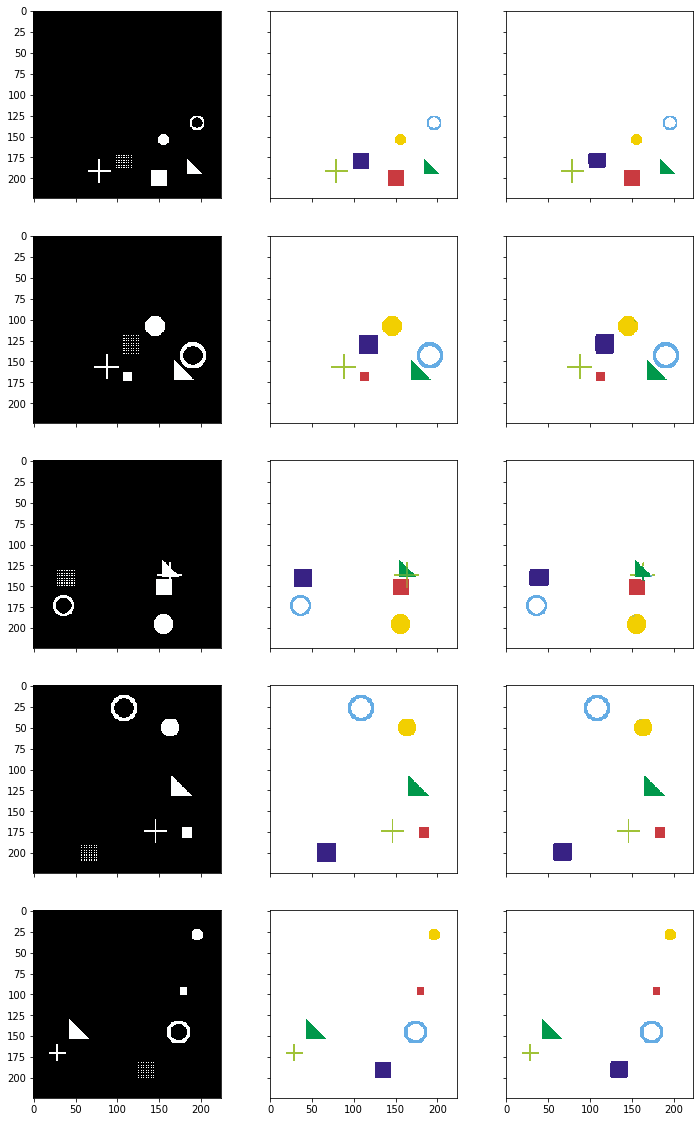

In [8]:
# import segmentation_models_pytorch as smp
# from segmentation.smp_effb4 import SMP_DIY
from segmentation.timm_unetb4 import UnetB4
from segmentation.timm_unetpp import UnetPP
from segmentation.timm_efficientnet import EfficientNet
from sim_dataset import SimDataset
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
import helper
from torchvision import transforms

device = 'cuda'
encoder = EfficientNet().get_encoder()
model = UnetPP(encoder, num_classes=6)
model = nn.DataParallel(model)
model.load_state_dict(torch.load('weights/Simulation_64Unet++ unfreeze-encoder_[06|10_19|51|36].h5'))
model.to(device)
model.eval()   # Set model to the evaluation mode

trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])
# Create another simulation dataset for test
test_dataset = SimDataset(5, transform = trans)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False, num_workers=0)

# Get the first batch
data = next(iter(test_loader))
inputs = data['image']
labels = data['mask']
inputs = inputs.to(device)
labels = labels.to(device)


# Predict
pred = model(inputs)
# The loss functions include the sigmoid function.
pred = F.sigmoid(pred)
pred = pred.data.cpu().detach().numpy()
print(pred.shape)

def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)

    return inp

# Change channel-order and make 3 channels for matplot
input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

# Map each channel (i.e. class) to each color
target_masks_rgb = [helper.masks_to_colorimg(x) for x in labels.cpu().numpy()]
pred_rgb = [helper.masks_to_colorimg(x) for x in pred]

helper.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

In [13]:
from collections import OrderedDict
ld = torch.load('best_weights/CASIA_64_ELA.h5')
newdict = OrderedDict()
for x in ld.keys():
    if 'base_model' in x:
        z = x.replace('.base_model','')
        newdict[z] = ld[x]
    else:
        newdict[x] = ld[x]

In [27]:
import segmentation.merged_net
reload(segmentation.merged_net)

from segmentation.timm_unetpp import UnetPP
from segmentation.merged_net import SRM_Classifer

classifier = SRM_Classifer().to('cuda')
classifier = nn.DataParallel(classifier)
classifier.load_state_dict(torch.load('best_weights/CASIA_64_ELA.h5'))
print(classifier.eval())
o
encoder = SRM_Classifer()
localizer = UnetPP(encoder, in_channels=54, num_classes=1)
localizer.to('cuda')
localizer = nn.DataParallel(localizer)
localizer.load_state_dict(torch.load('best_weights/CASIA_64_UNETPP_END-END.h5'))
print(localizer.eval())

DataParallel(
  (module): SRM_Classifer(
    (srm_conv): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (bayer_conv): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (rgb_conv): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (ela_net): Sequential(
      (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (encoder): Encoder(
      (stem): Sequential(
        (0): Conv2dSame(54, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      

In [3]:
import albumentations.pytorch

df = pd.read_csv(f"casia_64.csv").reset_index(drop=True)
rows = df[df["fold"] == 9]

real = rows[rows["label"] == 0].sample(n=10)
fakes = rows[rows["label"] == 1].sample(n=10)

data = pd.concat([fakes, real])
data = data.values

normalize = {
    "mean": [0.42468103282400615, 0.4259826707370029, 0.38855473517307415],
    "std": [0.2744059987371694, 0.2684138285232067, 0.29527622263685294],
}
valid_aug = albumentations.Compose(
    [
        augmentations.transforms.Resize(224, 224, interpolation=cv2.INTER_AREA, always_apply=True, p=1),
        albumentations.Normalize(mean=normalize['mean'], std=normalize['std'], always_apply=True, p=1),
        albumentations.pytorch.ToTensor()
    ],
    additional_targets={'ela':'image'}
)

Dice Loss:0.09562963247299194
Dice:0.9043703675270081, IOU:0.8254343867301941, Label:tensor([[0.8948]])


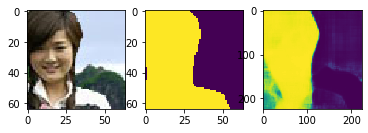

Dice Loss:0.535085916519165
Dice:0.4649140536785126, IOU:0.3028586506843567, Label:tensor([[0.8976]])


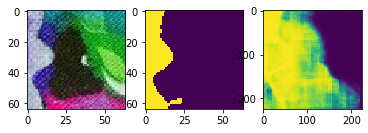

Dice Loss:0.02807760238647461
Dice:0.9719223976135254, IOU:0.9453784823417664, Label:tensor([[0.9058]])


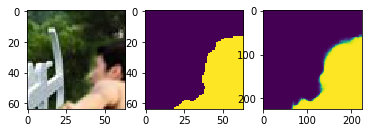

Dice Loss:0.191489577293396
Dice:0.808510422706604, IOU:0.6785711646080017, Label:tensor([[0.9010]])


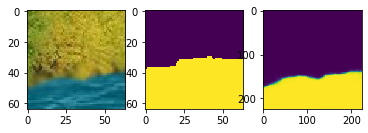

Dice Loss:0.0478367805480957
Dice:0.9521632194519043, IOU:0.9086941480636597, Label:tensor([[0.8936]])


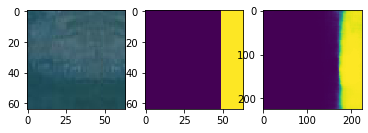

Dice Loss:0.3708534836769104
Dice:0.6291465163230896, IOU:0.4589451551437378, Label:tensor([[0.8816]])


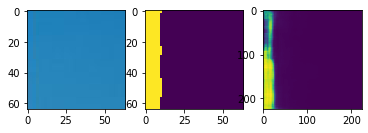

Dice Loss:0.16058605909347534
Dice:0.8394139409065247, IOU:0.7232673168182373, Label:tensor([[0.8668]])


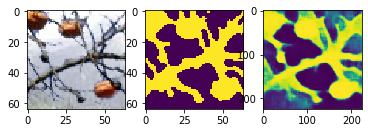

Dice Loss:0.009598791599273682
Dice:0.9904012084007263, IOU:0.9809849262237549, Label:tensor([[0.8979]])


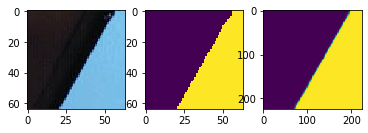

Dice Loss:0.012291967868804932
Dice:0.9877080321311951, IOU:0.9757145643234253, Label:tensor([[0.8984]])


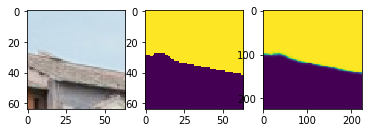

Dice Loss:0.047695934772491455
Dice:0.9523040652275085, IOU:0.9089508056640625, Label:tensor([[0.9021]])


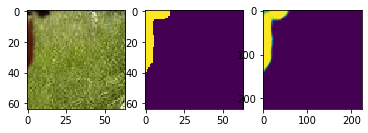

Dice Loss:0.0
Dice:0.0, IOU:0.0, Label:tensor([[0.6628]])


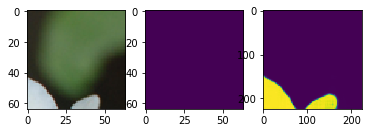

Dice Loss:0.0
Dice:0.0, IOU:0.0, Label:tensor([[0.1002]])


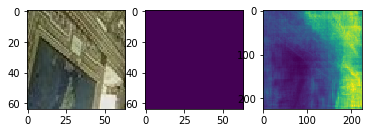

Dice Loss:0.0
Dice:0.0, IOU:0.0, Label:tensor([[0.0965]])


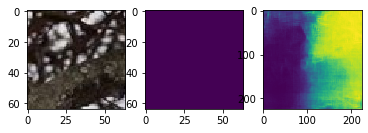

Dice Loss:0.0
Dice:0.0, IOU:0.0, Label:tensor([[0.0975]])


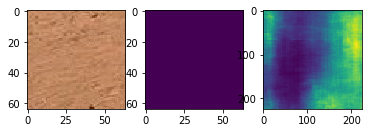

Dice Loss:0.0
Dice:0.0, IOU:0.0, Label:tensor([[0.1007]])


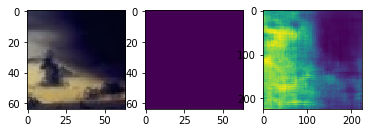

Dice Loss:0.0
Dice:0.0, IOU:0.0, Label:tensor([[0.1010]])


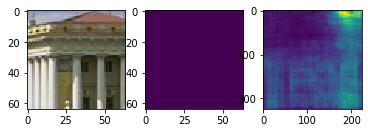

Dice Loss:0.0
Dice:0.0, IOU:0.0, Label:tensor([[0.1001]])


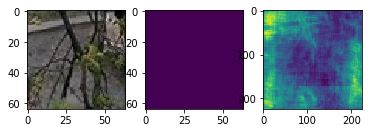

Dice Loss:0.0
Dice:0.0, IOU:0.0, Label:tensor([[0.0943]])


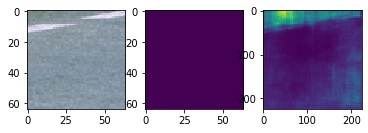

Dice Loss:0.0
Dice:0.0, IOU:0.0, Label:tensor([[0.0982]])


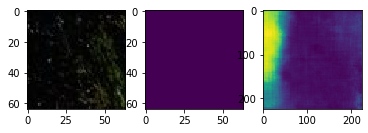

Dice Loss:0.0
Dice:0.0, IOU:0.0, Label:tensor([[0.0970]])


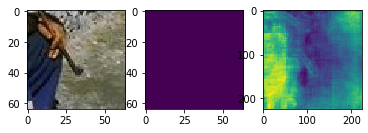

Total Dice:0.0, Total IOU:0.0
Best Dice: -1, Count = 0.0, IDX : 0
Best IOU: -1, Count = 0.0, IDX : 0
Total Dice2:0.0, Total IOU2:0.0


In [26]:
from pytorch_toolbelt import losses
from utils import *
import seg_metrics

root_dir = 'Image_Manipulation_Dataset/CASIA_2.0/image_patch_64'
for row in data:
    image_name, image_patch, mask_patch, label, fold, ela = row

    image_path = os.path.join(root_dir, image_name, image_patch)
    ela_path = os.path.join(root_dir, image_name, ela)

    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    ela_image = cv2.imread(ela_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ela_image = cv2.cvtColor(ela_image, cv2.COLOR_BGR2RGB)

    if not isinstance(mask_patch, str) and np.isnan(mask_patch):
        mask_image = np.zeros((image.shape[0], image.shape[1]))
    else:
        mask_path = os.path.join(root_dir, image_name, mask_patch)
        mask_image = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    trans = valid_aug(image=image, mask=mask_image, ela=ela_image)
    tensor = trans["image"].unsqueeze(0).cuda()
    mask_tensor = trans["mask"].unsqueeze(0).cuda()
    ela_tensor = trans["ela"].unsqueeze(0).cuda()

    dice_tot = AverageMeter()
    jaccard_tot = AverageMeter()
    preds = []
    targets = []
    labels = []
    with torch.no_grad():
        out_label, _ = classifier(tensor, ela_tensor)
        out_label = F.logsigmoid(out_label.cpu()).exp()

        out_mask = localizer(tensor, ela_tensor)
        out_mask = F.logsigmoid(out_mask.cpu()).exp()
        mask_tensor = mask_tensor.cpu()

        dice = losses.functional.soft_dice_score(out_mask, mask_tensor)
        dice_tot.update(dice)
        jaccard = losses.functional.soft_jaccard_score(out_mask, mask_tensor)
        jaccard_tot.update(jaccard)

        preds.append(out_mask)
        targets.append(mask_tensor)
        labels.append(out_label)

    loss = losses.DiceLoss(mode='binary', log_loss=False, from_logits=False)
    dice_loss = loss(out_mask, mask_tensor)
    print(f"Dice Loss:{dice_loss}")
    print(f"Dice:{dice}, IOU:{jaccard}, Label:{out_label}")
    plt.figure(1)
    plt.subplot(131)
    plt.imshow(image)

    plt.subplot(132)
    plt.imshow(mask_image)

    plt.subplot(133)
    plt.imshow(image2np(out_mask.squeeze(0)))
    plt.show()

print(f"Total Dice:{dice_tot.avg}, Total IOU:{jaccard_tot.avg}")
dice_tot2, best_dice = seg_metrics.dice_coeff(preds, targets)  
jaccard_tot2, best_iou = seg_metrics.jaccard_coeff(preds, targets) 
print(f"Total Dice2:{dice_tot2.item()}, Total IOU2:{jaccard_tot2.item()}")

In [9]:
from imd_dataset import IMD
df = pd.read_csv('cmfd_FULL.csv')

normalize = {
    "mean": [0.42468103282400615, 0.4259826707370029, 0.38855473517307415],
    "std": [0.2744059987371694, 0.2684138285232067, 0.29527622263685294],
}
valid_aug = albumentations.Compose(
    [
        augmentations.transforms.Resize(224, 224, interpolation=cv2.INTER_AREA, always_apply=True, p=1),
        albumentations.Normalize(mean=normalize['mean'], std=normalize['std'], always_apply=True, p=1),
        albumentations.pytorch.ToTensor()
    ],
    additional_targets={'ela':'image'}
)
train_dataset = IMD(
    dataframe=df,
    mode="train",
    val_fold=0,
    test_fold=5,
    root_dir='Image_Manipulation_Dataset/COCO_CMFD',
    patch_size='FULL',
    transforms=valid_aug,
    segment=False,
    equal_sample=False
)

real:2837, fakes:2838, mode = train


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
0.9
Image_Manipulation_Dataset/COCO_CMFD/fake/000000245915_fake.jpg


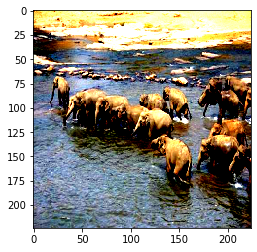

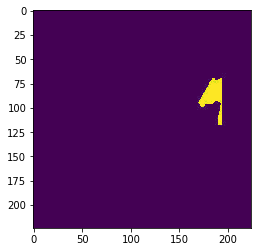

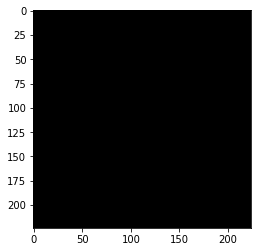

In [11]:
ex = train_dataset[5]

plt.figure()
plt.imshow(ex['image'].permute(1,2,0))

plt.figure()
plt.imshow(ex['mask'].permute(1,2,0).squeeze())

plt.figure()
plt.imshow(ex['ela'].permute(1,2,0))

print(ex['label'])
print(ex['image_path'])

plt.show()

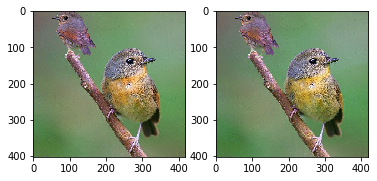

In [25]:
import imgaug.augmenters as iaa
aug = iaa.AddToHue(-250)

img = cv2.imread('Image_Manipulation_Dataset/CASIA_2.0/Tp/Tp_D_NNN_S_N_ani10201_ani10200_12412.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
new_img = aug.augment_image(image=img)

plt.figure(1)
plt.subplot(121)
plt.imshow(img)

plt.subplot(122)
plt.imshow(new_img)

plt.show()

(128, 128, 3) uint8
(128, 128, 3) uint8
(128, 128) uint8


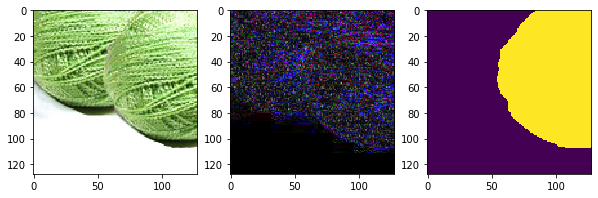

(128, 128, 3) uint8
(128, 128, 3) uint8
(128, 128) uint8


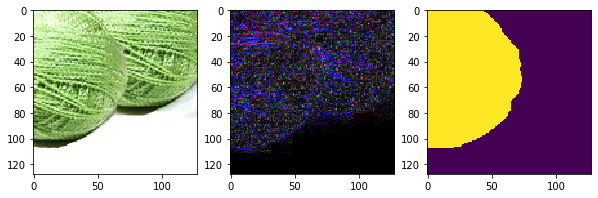

torch.Size([3, 224, 224]) torch.FloatTensor
torch.Size([3, 224, 224]) torch.FloatTensor
torch.Size([224, 224]) torch.ByteTensor
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


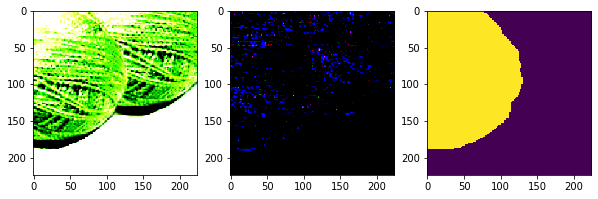

In [11]:
import albumentations
import albumentations.pytorch

image = cv2.imread('H:/image_manipulation/Image_Manipulation_Dataset/CASIA_2.0/image_patch_128/Tp_S_NNN_S_N_ani20014_ani20014_02057/1.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

ela = cv2.imread('H:/image_manipulation/Image_Manipulation_Dataset/CASIA_2.0/image_patch_128/Tp_S_NNN_S_N_ani20014_ani20014_02057/ela_1.png')
ela = cv2.cvtColor(ela, cv2.COLOR_BGR2RGB)

mask = cv2.imread('H:/image_manipulation/Image_Manipulation_Dataset/CASIA_2.0/image_patch_128/Tp_S_NNN_S_N_ani20014_ani20014_02057/1_gt.png', cv2.IMREAD_GRAYSCALE)
# mask = np.expand_dims(mask, 2)

print(image.shape, image.dtype)
print(ela.shape, ela.dtype)
print(mask.shape, mask.dtype)

# mask_tensor = torch.from_numpy(mask.transpose(2, 0, 1))
# print(mask_tensor.shape, mask_tensor.type())

plt.figure(figsize=(10,20))
plt.subplot(1,3,1)
plt.imshow(image)
plt.subplot(1,3,2)
plt.imshow(ela)
plt.subplot(1,3,3)
plt.imshow(mask)
plt.show()

geo_aug = albumentations.Compose(
    [
        albumentations.HorizontalFlip(p=1.0)
    ],
    additional_targets={'ela':'image'}
)

normalize = {
    "mean": [0.4535408213875562, 0.42862278450748387, 0.41780105499276865],
    "std": [0.2672804038612597, 0.2550410416463668, 0.29475415579144293],
}
train_aug = albumentations.Compose(
    [
        # albumentations.ElasticTransform(p=1.0, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        # albumentations.GridDistortion(p=1.0),
        # albumentations.OpticalDistortion(p=1.0, distort_limit=2, shift_limit=0.5)                  
        augmentations.geometric.resize.Resize(224, 224, interpolation=cv2.INTER_AREA, always_apply=True, p=1),
        albumentations.Normalize(mean=normalize['mean'], std=normalize['std'], always_apply=True, p=1),
        albumentations.pytorch.transforms.ToTensorV2()
    ],
    additional_targets={'ela':'image'}
)

data = geo_aug(image=image, mask=mask, ela=ela)
geo_image = data["image"]
geo_mask = data["mask"]
geo_ela = data["ela"]

print(geo_image.shape, geo_image.dtype)
print(geo_ela.shape, geo_ela.dtype)
print(geo_mask.shape, geo_mask.dtype)

plt.figure(figsize=(10,20))
plt.subplot(1,3,1)
plt.imshow(geo_image)
plt.subplot(1,3,2)
plt.imshow(geo_ela)
plt.subplot(1,3,3)
plt.imshow(geo_mask)
plt.show()

data = train_aug(image=geo_image, mask=geo_mask, ela=geo_ela)
aug_image = data["image"]
aug_mask = data["mask"]
aug_ela = data["ela"]


print(aug_image.shape, aug_image.type())
print(aug_ela.shape, aug_ela.type())
print(aug_mask.shape, aug_mask.type())

plt.figure(figsize=(10,20))
plt.subplot(1,3,1)
plt.imshow(aug_image.permute(1,2,0))
plt.subplot(1,3,2)
plt.imshow(aug_ela.permute(1,2,0))
plt.subplot(1,3,3)
plt.imshow(aug_mask)
plt.show()

In [88]:
print(aug_image.shape, aug_image.type())
print(aug_ela.shape, aug_ela.type())
print(aug_mask.shape, aug_mask.type())

torch.Size([3, 224, 224]) torch.FloatTensor
torch.Size([3, 224, 224]) torch.FloatTensor
torch.Size([1, 224, 224]) torch.FloatTensor


In [6]:
from torch.utils.data import Dataset, DataLoader
import albumentations
import albumentations.pytorch
import numpy as np

from segmentation.merged_net import SRM_Classifer

class DATASET(Dataset):
    def __init__(self):
        super().__init__()
        self.image = [np.random.randint(low=0, high=256, size=(256,256,3)) for i in range(32)]
        self.ela = [np.random.randint(low=0, high=256, size=(256,256,3)) for i in range(32)]
        self.mask = [np.random.randint(low=0, high=2, size=(256,256)) for i in range(32)]

        self.normalize = {
            "mean": [0.4535, 0.4286, 0.4178],
            "std": [0.2675, 0.2550, 0.2947],
        }
        self.train_aug = albumentations.Compose(
            [
                # albumentations.augmentations.geometric.resize.Resize(256, 256, interpolation=cv2.INTER_AREA, always_apply=True, p=1),
                # albumentations.Normalize(mean=normalize['mean'], std=normalize['std'], always_apply=True, p=1),
                albumentations.pytorch.transforms.ToTensorV2()
            ],
            additional_targets={'ela':'image'}
        )

    def __len__(self):
        return len(self.image)

    def __getitem__(self, index: int):
        
        # print(self.image[index].shape)
        # print(self.ela[index].shape)
        # print(self.mask[index].shape)
        

        data = self.train_aug(image=self.image[index], mask=self.mask[index], ela=self.ela[index])
        aug_image = data["image"]
        aug_mask = data["mask"]
        aug_ela = data["ela"]

        return {
            "image": aug_image,
            "ela" : aug_ela, 
            "mask": aug_mask
        }
dataset = DATASET()        
loader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)

model = SRM_Classifer()

i = 0
for batch in loader:
    images = batch["image"]
    elas = batch["ela"]
    masks = batch["mask"]

    print(i, "------------")
    print(images.shape)
    print(elas.shape)
    print(masks.shape)
    
    i+=1

    output 


0 ------------
torch.Size([8, 3, 256, 256])
torch.Size([8, 3, 256, 256])
torch.Size([8, 256, 256])
1 ------------
torch.Size([8, 3, 256, 256])
torch.Size([8, 3, 256, 256])
torch.Size([8, 256, 256])
2 ------------
torch.Size([8, 3, 256, 256])
torch.Size([8, 3, 256, 256])
torch.Size([8, 256, 256])
3 ------------
torch.Size([8, 3, 256, 256])
torch.Size([8, 3, 256, 256])
torch.Size([8, 256, 256])


In [11]:
np.zeros((image.shape[0], image.shape[1])).dtype

dtype('float64')

In [27]:
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa

# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# Define our sequence of augmentation steps that will be applied to every image
# All augmenters with per_channel=0.5 will sample one value _per image_
# in 50% of all cases. In all other cases they will sample new values
# _per channel_.

seq = iaa.Sequential(
    [
        iaa.SomeOf((0, 4),
            [   
                iaa.JpegCompression(compression=(75, 99)),
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                    iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                    iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                iaa.Sometimes(0.3, iaa.Invert(0.05, per_channel=True)), # invert color channels
                iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
                # # either change the brightness of the whole image (sometimes
                # # per channel) or change the brightness of subareas
                iaa.Sometimes(0.5,
                    iaa.OneOf([
                        iaa.Multiply((0.5, 1.5), per_channel=0.5),
                        iaa.FrequencyNoiseAlpha(
                            exponent=(-4, 0),
                            first=iaa.Multiply((0.5, 1.5), per_channel=True),
                            second=iaa.LinearContrast((0.5, 2.0))
                        )
                    ])
                ),
                iaa.LinearContrast((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
            ],
            random_order=True
        )
    ],
    random_order=True
)
# image = image.reshape(1,128,128,3)
print(image.shape)
images_aug = seq.augment_image(image)

(128, 128, 3)


In [1]:
import cv2

img = cv2.imread('G:/Image_Manipulation_Dataset/CASIA_2.0/Au/Au_ani_00001.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print(img.shape)
from dft_dwt import generate_dft_dwt_vector

vector = generate_dft_dwt_vector(img)
print(vector.shape)

(256, 384, 3)
(18, 256, 384)


In [5]:
mdl = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(inplace=True),
    nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(inplace=True)
)
summary(mdl, (3,256,256), device="cpu")

------------------------------------------------------------------------------------------
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 256, 256]        864
├─BatchNorm2d: 1-2                       [-1, 32, 256, 256]        64
├─ReLU: 1-3                              [-1, 32, 256, 256]        --
├─Conv2d: 1-4                            [-1, 32, 256, 256]        9,216
├─BatchNorm2d: 1-5                       [-1, 32, 256, 256]        64
├─ReLU: 1-6                              [-1, 32, 256, 256]        --
Total params: 10,208
Trainable params: 10,208
Non-trainable params: 0
Total mult-adds (M): 660.60
------------------------------------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 64.00
Params size (MB): 0.04
Estimated Total Size (MB): 64.79
------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 256, 256]        864
├─BatchNorm2d: 1-2                       [-1, 32, 256, 256]        64
├─ReLU: 1-3                              [-1, 32, 256, 256]        --
├─Conv2d: 1-4                            [-1, 32, 256, 256]        9,216
├─BatchNorm2d: 1-5                       [-1, 32, 256, 256]        64
├─ReLU: 1-6                              [-1, 32, 256, 256]        --
Total params: 10,208
Trainable params: 10,208
Non-trainable params: 0
Total mult-adds (M): 660.60
------------------------------------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 64.00
Params size (MB): 0.04
Estimated Total Size (MB): 64.79
------------------------------------------------------------------------------------------